In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense, Dropout
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import sys

Using TensorFlow backend.


In [2]:
# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [3]:
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector

    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

In [4]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [5]:
# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 400

In [6]:
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
z (Lambda)

In [7]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
y = Dropout(intermediate_dim,.3)(x)
outputs = Dense(original_dim, activation='sigmoid')(y)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1536      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 784)               402192    
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


In [8]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

-f:27: UserWarning: Output "decoder" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "decoder" during training.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 403972    
_________________________________________________________________
decoder (Model)              (None, 784)               403728    
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/400
60000/60000 [==============================] - 14s 240us/step - loss: 197.6804 - val_loss: 171.5306
Epoch 2/400
60000/60000 [==============================] - 13s 224us/step - loss: 168.2736 - val_loss: 166.3407
Epoch 3/400
60000/60000 [==============================] - 13s 224us/step - loss: 164.8467 - val_loss: 163.8665
Epoch 4/400
60

60000/60000 [==============================] - 14s 228us/step - loss: 144.5170 - val_loss: 149.1660
Epoch 67/400
60000/60000 [==============================] - 14s 227us/step - loss: 144.4895 - val_loss: 149.1591
Epoch 68/400
60000/60000 [==============================] - 14s 226us/step - loss: 144.4026 - val_loss: 149.1745
Epoch 69/400
60000/60000 [==============================] - 14s 226us/step - loss: 144.3468 - val_loss: 149.1827
Epoch 70/400
60000/60000 [==============================] - 14s 230us/step - loss: 144.2529 - val_loss: 149.0566
Epoch 71/400
60000/60000 [==============================] - 14s 226us/step - loss: 144.2077 - val_loss: 149.3825
Epoch 72/400
60000/60000 [==============================] - 14s 227us/step - loss: 144.1431 - val_loss: 149.0925
Epoch 73/400
60000/60000 [==============================] - 13s 224us/step - loss: 144.1091 - val_loss: 149.3235
Epoch 74/400
60000/60000 [==============================] - 13s 224us/step - loss: 144.0665 - val_loss: 148.8

60000/60000 [==============================] - 14s 227us/step - loss: 141.6304 - val_loss: 148.9537
Epoch 139/400
60000/60000 [==============================] - 14s 227us/step - loss: 141.6152 - val_loss: 148.9534
Epoch 140/400
60000/60000 [==============================] - 14s 228us/step - loss: 141.5702 - val_loss: 148.9447
Epoch 141/400
60000/60000 [==============================] - 14s 228us/step - loss: 141.5681 - val_loss: 149.0716
Epoch 142/400
60000/60000 [==============================] - 13s 224us/step - loss: 141.5643 - val_loss: 149.0457
Epoch 143/400
60000/60000 [==============================] - 13s 224us/step - loss: 141.5063 - val_loss: 149.1448
Epoch 144/400
60000/60000 [==============================] - 13s 225us/step - loss: 141.4893 - val_loss: 149.0865
Epoch 145/400
60000/60000 [==============================] - 14s 225us/step - loss: 141.4800 - val_loss: 149.0778
Epoch 146/400
60000/60000 [==============================] - 13s 223us/step - loss: 141.4818 - val_los

Epoch 210/400
60000/60000 [==============================] - 14s 225us/step - loss: 140.1748 - val_loss: 149.0956
Epoch 211/400
60000/60000 [==============================] - 14s 230us/step - loss: 140.1485 - val_loss: 149.2874
Epoch 212/400
60000/60000 [==============================] - 14s 229us/step - loss: 140.1164 - val_loss: 149.4699
Epoch 213/400
60000/60000 [==============================] - 14s 229us/step - loss: 140.1791 - val_loss: 149.4237
Epoch 214/400
60000/60000 [==============================] - 14s 229us/step - loss: 140.1176 - val_loss: 149.0913
Epoch 215/400
60000/60000 [==============================] - 14s 229us/step - loss: 140.0883 - val_loss: 149.3088
Epoch 216/400
60000/60000 [==============================] - 14s 229us/step - loss: 140.0808 - val_loss: 149.1815
Epoch 217/400
60000/60000 [==============================] - 14s 225us/step - loss: 140.0534 - val_loss: 149.3109
Epoch 218/400
60000/60000 [==============================] - 13s 223us/step - loss: 140.

Epoch 282/400
60000/60000 [==============================] - 14s 225us/step - loss: 139.2102 - val_loss: 149.5796
Epoch 283/400
60000/60000 [==============================] - 14s 227us/step - loss: 139.1418 - val_loss: 149.6232
Epoch 284/400
60000/60000 [==============================] - 14s 226us/step - loss: 139.1913 - val_loss: 149.5702
Epoch 285/400
60000/60000 [==============================] - 14s 228us/step - loss: 139.1233 - val_loss: 150.0263
Epoch 286/400
60000/60000 [==============================] - 14s 228us/step - loss: 139.1641 - val_loss: 149.7148
Epoch 287/400
60000/60000 [==============================] - 14s 229us/step - loss: 139.1064 - val_loss: 149.4626
Epoch 288/400
60000/60000 [==============================] - 14s 228us/step - loss: 139.0928 - val_loss: 149.9184
Epoch 289/400
60000/60000 [==============================] - 14s 228us/step - loss: 139.1074 - val_loss: 149.5734
Epoch 290/400
60000/60000 [==============================] - 14s 230us/step - loss: 139.

Epoch 354/400
60000/60000 [==============================] - 14s 227us/step - loss: 138.4271 - val_loss: 150.2416
Epoch 355/400
60000/60000 [==============================] - 14s 226us/step - loss: 138.4943 - val_loss: 150.2036
Epoch 356/400
60000/60000 [==============================] - 14s 226us/step - loss: 138.4458 - val_loss: 150.2671
Epoch 357/400
60000/60000 [==============================] - 14s 226us/step - loss: 138.4614 - val_loss: 150.3392
Epoch 358/400
60000/60000 [==============================] - 13s 225us/step - loss: 138.4119 - val_loss: 150.1879
Epoch 359/400
60000/60000 [==============================] - 13s 224us/step - loss: 138.4311 - val_loss: 149.9027
Epoch 360/400
60000/60000 [==============================] - 14s 230us/step - loss: 138.4139 - val_loss: 150.3530
Epoch 361/400
60000/60000 [==============================] - 14s 227us/step - loss: 138.4377 - val_loss: 150.3050
Epoch 362/400
60000/60000 [==============================] - 14s 228us/step - loss: 138.

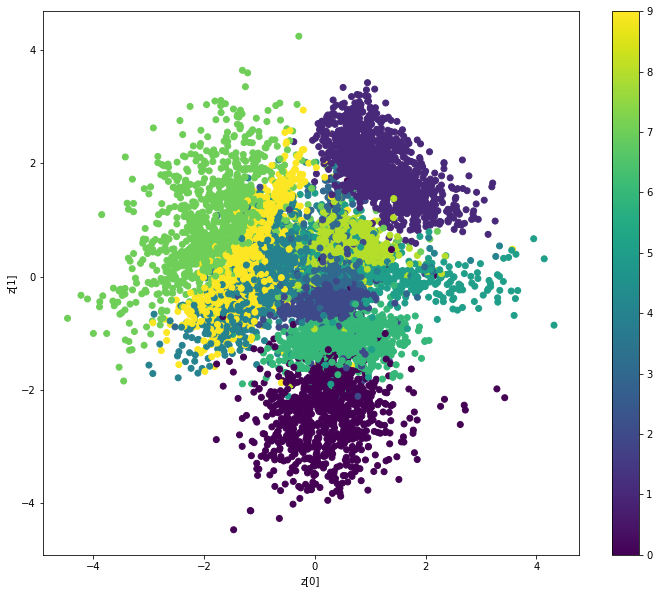

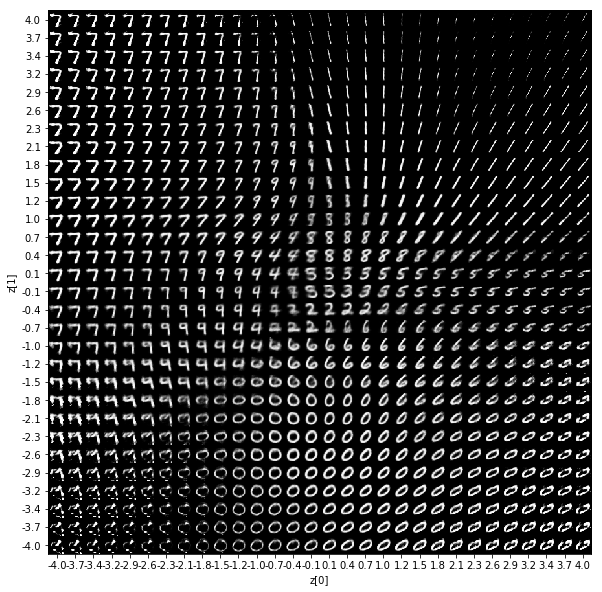

In [9]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    help_ = "Load h5 model trained weights"
    parser.add_argument("-w", "--weights", help=help_)
    help_ = "Use mse loss instead of binary cross entropy (default)"
    parser.add_argument("-m",
                        "--mse",
                        help=help_, action='store_true')
    sys.argv = ['-f']
    args = parser.parse_args()
    models = (encoder, decoder)
    data = (x_test, y_test)

    # VAE loss = mse_loss or xent_loss + kl_loss
    if args.mse:
        reconstruction_loss = mse(inputs, outputs)
    else:
        reconstruction_loss = binary_crossentropy(inputs,
                                                  outputs)

    reconstruction_loss *= original_dim
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')
    vae.summary()
    #plot_model(vae,
    #           to_file='vae_mlp.png',
    #           show_shapes=True)

    if args.weights:
        vae.load_weights(args.weights)
    else:
        # train the autoencoder
        vae.fit(x_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(x_test, None))
        vae.save_weights('vae_mlp_mnist.h5')

    plot_results(models,
                 data,
                 batch_size=batch_size,
                 model_name="vae_mlp")